## EDA

In [16]:
import pandas as pd

train_path = r"/kaggle/input/news-classification/classification/classification_news_train.jsonl"
eval_path = r"/kaggle/input/news-classification/classification/classification_news_eval.jsonl"
train_data = pd.read_json(train_path, lines=True)
eval_data = pd.read_json(eval_path, lines=True)
print(train_data[:2])

   category                                           headline  \
0  WELLNESS     Dr. Seuss' Prescription For A Bad Day (PHOTOS)   
1  POLITICS  Bill Would Turn Veteran Bars Into Wellness Cen...   

            authors                                               link  \
0                    https://www.huffingtonpost.com/entry/dr-seuss-...   
1  Michael McAuliff  https://www.huffingtonpost.com/entry/bill-vet-...   

                                   short_description       date  
0  GPS Guides are our way of showing you what has... 2013-07-24  
1  "When you look at some of the struggles our ve... 2015-11-10  


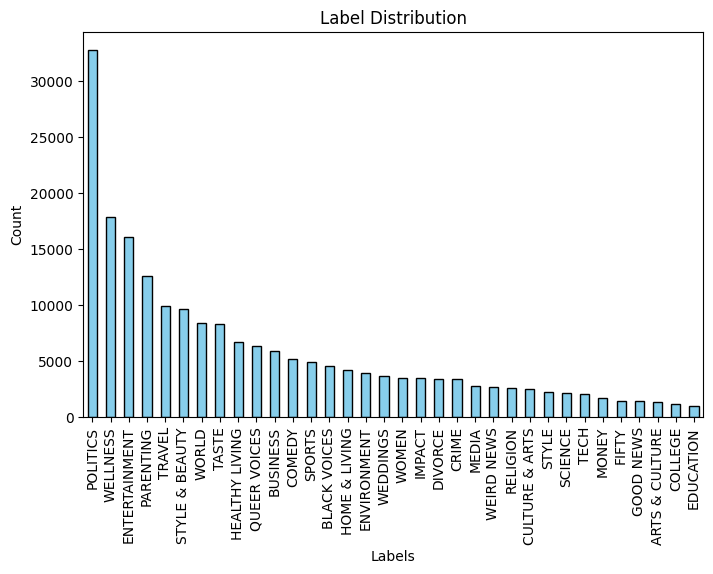


Class Imbalance Ratio (max:min): 32.61


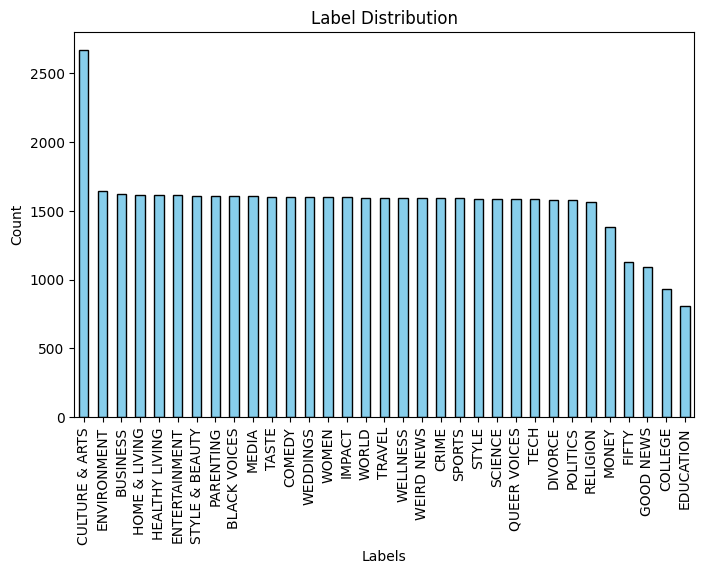


Class Imbalance Ratio (max:min): 3.31


In [24]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_dist(df):
    label_counts = df['category'].value_counts()
    
    
    plt.figure(figsize=(8, 5))
    label_counts.plot(kind='bar', color='skyblue', edgecolor='black')
    plt.title("Label Distribution")
    plt.xlabel("Labels")
    plt.ylabel("Count")
    plt.show()
    
    
    # total_samples = len(df)
    # proportions = label_counts / total_samples * 100
    # print("Label Counts:\n", label_counts)
    # print("\nProportions (%):\n", proportions)
    
    max_count = label_counts.max()
    min_count = label_counts.min()
    imbalance_ratio = max_count / min_count
    print(f"\nClass Imbalance Ratio (max:min): {imbalance_ratio:.2f}")
    
full_path = r"/kaggle/input/news-classification/classification_news.jsonl"
full = pd.read_json(full_path, lines=True)
plot_dist(full)
plot_dist(train_data)


## Correlation between Dates and Categories

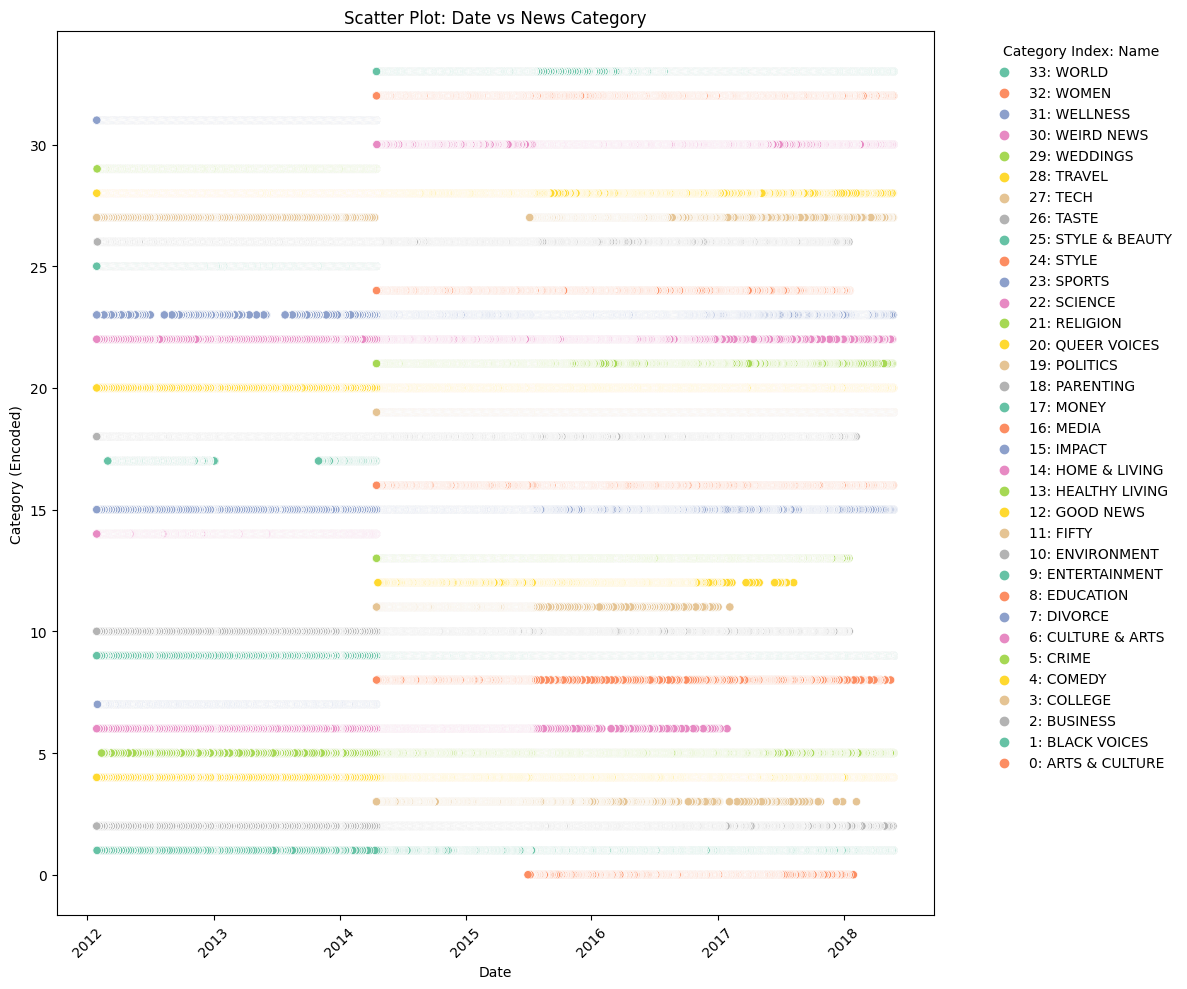

In [25]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def plot_date(df):
    # Step 1: Convert dates to datetime
    df['date'] = pd.to_datetime(df['date'])
    
    # Step 2: Encode categories numerically
    df['category_numeric'] = df['category'].astype('category').cat.codes
    
    # Step 3: Create a mapping of category index and name
    category_mapping = {cat: f"{i}: {cat}" for i, cat in enumerate(df['category'].astype('category').cat.categories)}
    
    # Step 4: Sort the categories by the numerical encoding
    category_order = sorted(df['category'].astype('category').cat.codes.unique(), reverse=True)
    
    # Step 5: Create the scatter plot with correct hue order
    plt.figure(figsize=(12, 10))
    scatter = sns.scatterplot(
        x='date',
        y='category_numeric',
        data=df,
        hue='category',
        palette='Set2',
        hue_order=[df['category'].astype('category').cat.categories[i] for i in category_order]  # Ensure hue order is sorted
    )
    
    # Step 6: Modify the legend labels to match the y-axis (numerical order)
    handles, labels = scatter.get_legend_handles_labels()
    
    # Sort the legend labels to match the numerical order of categories
    sorted_labels = [category_mapping[label] for label in sorted(labels, key=lambda x: -df['category'].astype('category').cat.codes[df['category'] == x].values[0])]
    
    # Update the legend with the sorted labels (matching y-axis order)
    scatter.legend(handles=handles, labels=sorted_labels, title="Category Index: Name", bbox_to_anchor=(1.05, 1), loc='upper left', frameon=False)
    
    # Customizing the plot
    plt.title("Scatter Plot: Date vs News Category")
    plt.xlabel("Date")
    plt.ylabel("Category (Encoded)")
    plt.xticks(rotation=45)  # Rotate date labels for better readability
    plt.tight_layout()  # Adjust layout to prevent clipping
    plt.savefig("date vs. category.png")
    plt.show()

plot_date(df)

There is some correlation between dates and categories, but this is probably a bias in the dataset. We should exclude dates from the features to be fair. (I only realized this later.)

## Experiments on smaller datasets

In [1]:
from transformers import (

    BertTokenizer,

    BertForSequenceClassification,

    Trainer,

    TrainingArguments,

)

from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score, precision_recall_fscore_support

from torch.utils.data import Dataset

import torch

import pandas as pd

In [2]:
train_path = r"/kaggle/input/news-classification/classification/classification_news_train.jsonl"

eval_path = r"/kaggle/input/news-classification/classification/classification_news_eval.jsonl"

train_data = pd.read_json(train_path, lines=True)

eval_data = pd.read_json(eval_path, lines=True)

# Take 5% random samples
train_sample = train_data.sample(frac=0.05, random_state=42)  # 5% of training data
eval_sample = eval_data.sample(frac=0.05, random_state=42)    # 5% of evaluation data

# Display the sampled data
print("Train Sample Shape:", train_sample.shape)
print("Eval Sample Shape:", eval_sample.shape)

Train Sample Shape: (2560, 6)
Eval Sample Shape: (641, 6)


In [3]:
def preprocess(concat, train_sample, eval_sample):
    train_texts = concat(train_sample)
    eval_texts = concat(eval_sample)
    
    length_train = len(train_sample["category"])
    
    labels, unique_labels = pd.factorize(pd.concat([train_sample["category"], eval_sample["category"]], axis=0))
    
    train_labels = labels[:length_train]
    
    eval_labels = labels[length_train:]

    return train_texts, train_labels, eval_texts, eval_labels, unique_labels

In [4]:
def encode(train_texts, eval_texts, tokenizer):
    train_encodings = tokenizer(list(train_texts), truncation=True, padding=True)

    eval_encodings = tokenizer(list(eval_texts), truncation=True, padding=True)

    return train_encodings, eval_encodings

In [5]:
class NewsDataset(Dataset):

    def __init__(self, encodings, labels):

        self.encodings = encodings

        self.labels = labels



    def __len__(self):

        return len(self.labels)



    def __getitem__(self, idx):

        return {

            "input_ids": torch.tensor(self.encodings["input_ids"][idx]),

            "attention_mask": torch.tensor(self.encodings["attention_mask"][idx]),

            "labels": torch.tensor(self.labels[idx]),

        }

In [6]:
def create_dataset(train_encodings, eval_encodings, train_labels, eval_labels):
    train_dataset = NewsDataset(train_encodings, train_labels.tolist())

    eval_dataset = NewsDataset(eval_encodings, eval_labels.tolist())

    return train_dataset, eval_dataset

In [7]:
def compute_metrics(pred):

    labels = pred.label_ids

    preds = pred.predictions.argmax(-1)

    precision, recall, f1, _ = precision_recall_fscore_support(

        labels, preds, average="macro", zero_division=0

    )

    acc = accuracy_score(labels, preds)

    return {"accuracy": acc, "f1": f1, "precision": precision, "recall": recall}

In [8]:
def train(name, train_dataset, eval_dataset, unique_labels, tokenzier, epochs = 6):

    model = BertForSequenceClassification.from_pretrained(

    "bert-base-uncased", num_labels=len(unique_labels)

)
    model.resize_token_embeddings(len(tokenizer))
    # Training arguments
    import wandb
    training_args = TrainingArguments(
    
        output_dir=name,
    
        eval_strategy="epoch",
    
        learning_rate=2e-5,
    
        per_device_train_batch_size=16,
    
        per_device_eval_batch_size=16,
    
        num_train_epochs=epochs,
    
        weight_decay=0.01,
    
        logging_dir="./logs",
    
        logging_steps=10,
    
        save_strategy="epoch",
    
    )
    
    
    
    # Trainer
    
    trainer = Trainer(
    
        model=model,
    
        args=training_args,
    
        train_dataset=train_dataset,
    
        eval_dataset=eval_dataset,
    
        compute_metrics=compute_metrics
    
    )


    trainer.train()
    wandb.finish()

    return model

In [9]:
def pipeline(concat, name, tokenizer, train_data, eval_data, epochs=6):
    train_texts, train_labels, eval_texts, eval_labels, unique_labels = preprocess(concat, train_data, eval_data)
    train_encodings, eval_encodings = encode(train_texts, eval_texts, tokenizer)
    train_dataset, eval_dataset = create_dataset(train_encodings, eval_encodings, train_labels, eval_labels)
    model = train(name, train_dataset, eval_dataset, unique_labels, tokenizer, epochs)
    return model

## No Delimiter

In [10]:
def concatenate_no_delimiter(data: pd.DataFrame):
    # print(data)
    data["concatenated"] = data.apply(
        (
            lambda row: f"{row['headline']}{row['authors']}{row['link']}{row['short_description']}{row['date']}"

        ),
        axis=1,
    )
    
    return data["concatenated"]

In [11]:
import wandb
wandb.finish()

In [14]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
pipeline(concatenate_no_delimiter, "no-delimiter-concat", tokenizer, train_sample, eval_sample)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
wandb: Currently logged in as: zixuan-cao (zixuan-cao-ludwig-maximilianuniversity-of-munich). Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,3.031800,3.041130,0.260530,0.199505,0.257110,0.251672
2,2.334100,2.349382,0.486739,0.436102,0.530206,0.473730
3,1.931800,1.963627,0.553822,0.495135,0.536865,0.535640
4,1.329700,1.734847,0.606864,0.567425,0.631825,0.587525
5,1.252600,1.647424,0.625585,0.589940,0.650780,0.606551
6,1.062600,1.604479,0.624025,0.585813,0.635132,0.604214


eval/accuracy,▁▅▇███
eval/f1,▁▅▆███
eval/loss,█▅▃▂▁▁
eval/precision,▁▆▆███
eval/recall,▁▅▇███
eval/runtime,▃▁▂▅▃█
eval/samples_per_second,▆█▇▄▆▁
eval/steps_per_second,▆█▇▄▆▁
train/epoch,▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇█
train/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇▇██
train/grad_norm,▁▂▂▄▁▅▃▆▄▂▄▆▄▆▃▄▂▃▂▇█▇▆▅▂▄▂▂▃▂▂▇▄▃▁▂▅▃▂▅


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

## [SEP] Concatenation

In [29]:
def concatenate_naive(data: pd.DataFrame):
    # print(data)
    data["concatenated"] = data.apply(
        (
            lambda row: f"{row['headline']}[SEP]{row['authors']}[SEP]{row['link']}[SEP]{row['short_description']}[SEP]{row['date']}"

        ),
        axis=1,
    )
    
    return data["concatenated"]

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
pipeline(concatenate_naive, "[SEP]concat", tokenizer, train_sample, eval_sample)

## HTML style

In [39]:
def concatenate_html(data: pd.DataFrame):
    # link example: https://www.huffingtonpost.com/entry/11-no-fail-ways-to-succee_b_8904794.html
    # def clean_link(link):
    #     matched = re.search(r"entry/(.*?)_", link)
    #     clean = matched.group(1).replace('-', ' ') if matched else ""
    #     return clean
        
    data["concatenated"] = data.apply(
        (
            lambda row: f"<headline>{row['headline']}</headline>"
            f"<authors>{row['authors']}</authors>"
            f"<link>{row['link']}</link>"
            f"<description>{row['short_description']}</description>" # Aligned with other f-strings
            f"<date>{row['date']}</date>"
        ),
        axis=1,
    )
    return data["concatenated"]

In [40]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
pipeline(concatenate_html, "HTML-concat", tokenizer, train_sample, eval_sample)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,2.915600,2.881383,0.327613,0.272089,0.378739,0.313635
2,2.259000,2.263738,0.521061,0.467530,0.519418,0.497452
3,1.825800,1.919904,0.591264,0.539113,0.552543,0.564273
4,1.294300,1.740851,0.609984,0.565379,0.594760,0.586581
5,1.139600,1.656213,0.619345,0.579657,0.620093,0.595547
6,0.997600,1.619951,0.628705,0.585296,0.614592,0.603807


eval/accuracy,▁▅▇███
eval/f1,▁▅▇███
eval/loss,█▅▃▂▁▁
eval/precision,▁▅▆▇██
eval/recall,▁▅▇███
eval/runtime,▁▁▄▄█▅
eval/samples_per_second,██▅▅▁▄
eval/steps_per_second,██▅▅▁▄
train/epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇██
train/global_step,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇███
train/grad_norm,▂▁▁▂▄▄▄▅▄▄▅▅▅▅█▆▅▆▅▄▇█▆▅█▆▅▆▅▆▆▆▆▅▆▄▅▄▃▅


## HTML with special tokens

In [41]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
special_tokens = {'additional_special_tokens': ['<headline>', '</headline>', '<authors>', '</authors>', '<description>', "</description>", "<link>", "</link>", "<date>", "</date>"]}
tokenizer.add_special_tokens(special_tokens)

pipeline(concatenate_html, "HTML-concat-with-special-tokens", tokenizer, train_sample, eval_sample)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,2.877100,2.805384,0.343214,0.281516,0.448577,0.321537
2,2.136900,2.221457,0.511700,0.468003,0.513642,0.498065
3,1.726100,1.882300,0.603744,0.560868,0.577411,0.580941
4,1.231800,1.715648,0.608424,0.571196,0.599343,0.585260
5,1.106800,1.636537,0.606864,0.562346,0.566361,0.581518
6,0.928500,1.603624,0.624025,0.585467,0.613371,0.600183


eval/accuracy,▁▅▇███
eval/f1,▁▅▇█▇█
eval/loss,█▅▃▂▁▁
eval/precision,▁▄▆▇▆█
eval/recall,▁▅████
eval/runtime,▃▃▄▃▁█
eval/samples_per_second,▆▆▅▆█▁
eval/steps_per_second,▆▆▅▆█▁
train/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇███
train/global_step,▁▁▁▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇████
train/grad_norm,▁▁▁▃▂▅▃▂▃▃▃▄▃▅▂▄█▄▄▃▃▃▅▄▅▃▂▅▅▂▄▆▂▄▃▃▄▆▃▃


## Extract Link Keywords

keywords from the link are extracted.

In [13]:
import re
def concatenate_keywords(data: pd.DataFrame):
    # link example: https://www.huffingtonpost.com/entry/11-no-fail-ways-to-succee_b_8904794.html
    def clean_link(link):
        matched = re.search(r"entry/(.*?)_", link)
        clean = matched.group(1).replace('-', ' ') if matched else link
        return clean
        
    data["concatenated"] = data.apply(
        (
            lambda row: f"{row['headline']}[SEP]{row['authors']}[SEP]Keywords or Link: {clean_link(row['link'])}[SEP]{row['short_description']}[SEP]{row['date']}"

        ),
        axis=1
    )
    return data["concatenated"]

In [15]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
pipeline(concatenate_naive, "[SEP]with-keywords-from-link", tokenizer, train_sample, eval_sample)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: zixuan-cao (zixuan-cao-ludwig-maximilianuniversity-of-munich). Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,2.959100,2.855769,0.322933,0.239510,0.303994,0.303903
2,2.197200,2.210157,0.528861,0.475940,0.517955,0.513462
3,1.759400,1.869807,0.570983,0.520498,0.530028,0.550028
4,1.190100,1.691911,0.599064,0.548252,0.555099,0.574956
5,1.121200,1.599813,0.608424,0.559599,0.558909,0.586488
6,0.944600,1.565068,0.619345,0.570924,0.570180,0.595998


eval/accuracy,▁▆▇███
eval/f1,▁▆▇███
eval/loss,█▄▃▂▁▁
eval/precision,▁▇▇███
eval/recall,▁▆▇▇██
eval/runtime,▁█▁▅▂▁
eval/samples_per_second,█▁█▄▇█
eval/steps_per_second,█▁█▄▇█
train/epoch,▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇█
train/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇█
train/grad_norm,▁▂▄▃▃▃▄▄▃▄▅▄▄▅▅▃▃▄▆▅▃▄▆▄▃▅▄▄▅▄▃▅▃▅▄▄█▅▄▃


## [SEP] wihout-dates

In [17]:
def concatenate_naive_without_date(data: pd.DataFrame):
    # print(data)
    data["concatenated"] = data.apply(
        (
            lambda row: f"{row['headline']}[SEP]{row['authors']}[SEP]{row['link']}[SEP]{row['short_description']}"

        ),
        axis=1,
    )
    
    return data["concatenated"]

In [18]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
pipeline(concatenate_naive_without_date, "[SEP] wihout-dates", tokenizer, train_sample, eval_sample)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,2.893800,2.796199,0.372855,0.306438,0.458687,0.350978
2,2.139100,2.173282,0.538222,0.485641,0.543252,0.514482
3,1.736200,1.835428,0.608424,0.558053,0.576162,0.581251
4,1.201800,1.653266,0.625585,0.572869,0.575745,0.593018
5,1.057800,1.568113,0.630265,0.591027,0.617271,0.606006
6,0.885600,1.541825,0.634945,0.592124,0.617836,0.606866


eval/accuracy,▁▅▇███
eval/f1,▁▅▇███
eval/loss,█▅▃▂▁▁
eval/precision,▁▅▆▆██
eval/recall,▁▅▇███
eval/runtime,█▁▂▃▇▆
eval/samples_per_second,▁█▇▆▂▃
eval/steps_per_second,▁█▇▆▂▃
train/epoch,▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇███
train/global_step,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇█
train/grad_norm,▁▁▁▄▅▄▄▃▆▆▄▆▅▅▆▆▅▅▆▇▆█▄▄▃█▇▄▅▇▄▇▃▄▆▇▅▂▄▂


## What we found from the expriments?

It seems that the best thing to do is just to leave the features untouched :c

We will adopt the naive concatenation with [SEP].

In [22]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
pipeline(concatenate_naive, "[SEP]full", tokenizer, train_data, eval_data, epochs=3)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: zixuan-cao (zixuan-cao-ludwig-maximilianuniversity-of-munich). Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.674800,0.718894,0.800296,0.794229,0.799775,0.795309
2,0.545500,0.637084,0.819713,0.815253,0.816562,0.816220
3,0.263400,0.634608,0.827199,0.823166,0.823233,0.823671


eval/accuracy,▁▆█
eval/f1,▁▆█
eval/loss,█▁▁
eval/precision,▁▆█
eval/recall,▁▆█
eval/runtime,█▁▆
eval/samples_per_second,▁█▃
eval/steps_per_second,▁█▃
train/epoch,▁▁▁▁▁▂▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇▇▇▇█
train/global_step,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▃▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇██
train/grad_norm,▄▃▄▃▄▆▄▂▄▆▆▄▅▄▃▃▃▄▄▃▄▇▂▁▆▄▅▃▅▇▅▃▃█▄▄▄▁▃▅


In [23]:
!zip -r /kaggle/working/model_checkpoint.zip /kaggle/working/[SEP]full/checkpoint-9600

  adding: kaggle/working/[SEP]full/checkpoint-9600/ (stored 0%)
  adding: kaggle/working/[SEP]full/checkpoint-9600/model.safetensors

/usr/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


 (deflated 7%)
  adding: kaggle/working/[SEP]full/checkpoint-9600/optimizer.pt (deflated 13%)
  adding: kaggle/working/[SEP]full/checkpoint-9600/training_args.bin (deflated 51%)
  adding: kaggle/working/[SEP]full/checkpoint-9600/config.json (deflated 66%)
  adding: kaggle/working/[SEP]full/checkpoint-9600/rng_state.pth (deflated 25%)
  adding: kaggle/working/[SEP]full/checkpoint-9600/scheduler.pt (deflated 56%)
  adding: kaggle/working/[SEP]full/checkpoint-9600/trainer_state.json (deflated 84%)


## HTML-Style training on the full dataset

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
special_tokens = {'additional_special_tokens': ['<headline>', '</headline>', '<authors>', '</authors>', '<description>', "</description>", "<link>", "</link>", "<date>", "</date>"]}
tokenizer.add_special_tokens(special_tokens)

pipeline(concatenate_html, "HTML-concat-with-special-tokens", tokenizer, train_data, eval_data)

Due to the limitation of computation resources, this part was trained in Google Colab. The performance after 3 epochs is recorded here as:  
Accuracy: 0.822 
F1-Score: 0.817 
Precison: 0.817 
Recall: 0.818 


## Full training without date
to see without "cheating", how good will it be. (This will also be trained on the full dataset.)

In [18]:
def concatenate_naive_without_date(data: pd.DataFrame):
    # print(data)
    data["concatenated"] = data.apply(
        (
            lambda row: f"{row['headline']}[SEP]{row['authors']}[SEP]{row['link']}[SEP]{row['short_description']}"

        ),
        axis=1,
    )
    
    return data["concatenated"]

In [23]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
pipeline(concatenate_naive_without_date, "[SEP]full-without-date-full", tokenizer, train_data, eval_data, epochs=2)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
wandb: Currently logged in as: zixuan-cao (zixuan-cao-ludwig-maximilianuniversity-of-munich). Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.714100,0.726017,0.800686,0.794241,0.798406,0.795844
2,0.622000,0.645452,0.818621,0.814045,0.814030,0.814790


eval/accuracy,▁█
eval/f1,▁█
eval/loss,█▁
eval/precision,▁█
eval/recall,▁█
eval/runtime,▁█
eval/samples_per_second,█▁
eval/steps_per_second,█▁
train/epoch,▁▁▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▄▄▄▄▄▅▅▅▆▆▇▇▇▇▇▇▇▇▇████
train/global_step,▁▁▁▁▁▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▄▄▄▄▅▅▅▆▆▆▆▆▇▇▇▇▇███
train/grad_norm,▃▃▄▄▄▃▃▆▇▅▅▅▃▄▄▅▄▅▅▄▄▄▅▁▆▆▃▅▆▄▅▂▄▇▅▆▇▅█▂


## Confusion Matrix

In [26]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import pandas as pd

In [105]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import transformers

# Load the trained model and tokenizer
model_path = '/kaggle/input/bert-base-news/transformers/default/1/news_checkpoint.pth'
tokenizer_name = 'bert-base-uncased'

# Define class labels (update according to your model's classes)
class_labels = ['WELLNESS', 'POLITICS', 'COMEDY', 'DIVORCE', 'WOMEN', 'BLACK VOICES',
       'ENTERTAINMENT', 'TRAVEL', 'WORLD', 'MONEY', 'TECH', 'CRIME', 'SPORTS',
       'STYLE & BEAUTY', 'BUSINESS', 'TASTE', 'WEDDINGS', 'HEALTHY LIVING',
       'IMPACT', 'RELIGION', 'HOME & LIVING', 'PARENTING', 'ENVIRONMENT',
       'SCIENCE', 'CULTURE & ARTS', 'QUEER VOICES', 'STYLE', 'GOOD NEWS',
       'MEDIA', 'COLLEGE', 'WEIRD NEWS', 'EDUCATION', 'FIFTY']  # Example, update this list with actual class names

id2label = {i: label for i, label in enumerate(class_labels)}
label2id = {v: k for k, v in id2label.items()}

tokenizer = AutoTokenizer.from_pretrained(tokenizer_name)
model_html = AutoModelForSequenceClassification.from_pretrained(tokenizer_name, num_labels=33, id2label=id2label, label2id=label2id)
model_html.load_state_dict(torch.load(model_path)["model_state_dict"])
model_html.eval()



`clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the fun

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [74]:
import torch
import numpy as np
from tqdm import tqdm  # Import tqdm for the progress bar

def predict(model, encoded_inputs):
    # Set device to GPU if available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Move the model to the selected device (GPU or CPU)
    model.to(device)
    
    # Ensure that encoded_inputs is also on the correct device
    encoded_inputs = {key: value.to(device) for key, value in encoded_inputs.items()}
    
    batch_size = 16  # Choose a batch size that fits your GPU memory
    predictions = []
    
    # Split the input into smaller batches
    # Using tqdm to show a progress bar for the loop
    for i in tqdm(range(0, len(encoded_inputs['input_ids']), batch_size), desc="Processing batches"):
        # Create a batch from the input data
        batch_inputs = {key: value[i:i+batch_size] for key, value in encoded_inputs.items()}
        
        # Perform inference on the GPU
        with torch.no_grad():
            outputs = model(**batch_inputs)
            batch_predictions = torch.argmax(outputs.logits, axis=1).cpu().numpy()  # Move to CPU for numpy conversion
            predictions.extend(batch_predictions)
    
    # Convert the list of predictions into a NumPy array
    predictions = np.array(predictions)
    return predictions


In [75]:
predctions = predict(model_sep, encoded_inputs)

Processing batches: 100%|██████████| 802/802 [01:46<00:00,  7.51it/s]


In [76]:
def draw_confusion_matrix(labels, predictions):
    import matplotlib.pyplot as plt
    import numpy as np
    from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
    
    # Compute the confusion matrix
    cm = confusion_matrix(labels, predictions)
    
    # Visualize the confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=unique_labels)
    fig, ax = plt.subplots(figsize=(10, 8)) 
    disp.plot(cmap=plt.cm.Blues, ax=ax)
    plt.xticks(rotation=45, ha="right")  
    plt.tight_layout()
    plt.title("Confusion Matrix")
    plt.show()


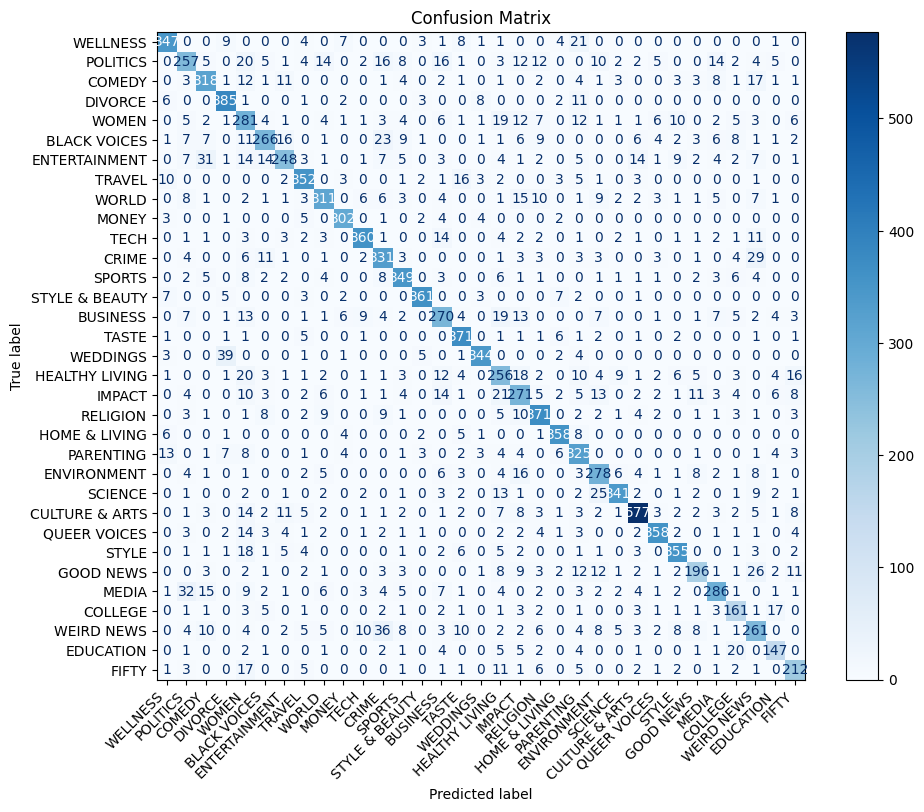

In [77]:
labels, unique_labels = pd.factorize(pd.concat([train_data["category"], eval_data["category"]], axis=0))
labels = labels[length_train:]
draw_confusion_matrix(labels, predictions)

In [70]:
class_labels = ['WELLNESS', 'POLITICS', 'COMEDY', 'DIVORCE', 'WOMEN', 'BLACK VOICES',
       'ENTERTAINMENT', 'TRAVEL', 'WORLD', 'MONEY', 'TECH', 'CRIME', 'SPORTS',
       'STYLE & BEAUTY', 'BUSINESS', 'TASTE', 'WEDDINGS', 'HEALTHY LIVING',
       'IMPACT', 'RELIGION', 'HOME & LIVING', 'PARENTING', 'ENVIRONMENT',
       'SCIENCE', 'CULTURE & ARTS', 'QUEER VOICES', 'STYLE', 'GOOD NEWS',
       'MEDIA', 'COLLEGE', 'WEIRD NEWS', 'EDUCATION', 'FIFTY']  # Example, update this list with actual class names

id2label = {i: label for i, label in enumerate(class_labels)}
label2id = {v: k for k, v in id2label.items()}
# Load the model from a local path or Hugging Face Hub with safetensors
model_html = AutoModelForSequenceClassification.from_pretrained(
    "/kaggle/input/sepnews-full/transformers/default/2", 
    use_safetensors=True,
    id2label=id2label, label2id=label2id
)

Processing batches: 100%|██████████| 802/802 [01:46<00:00,  7.50it/s]


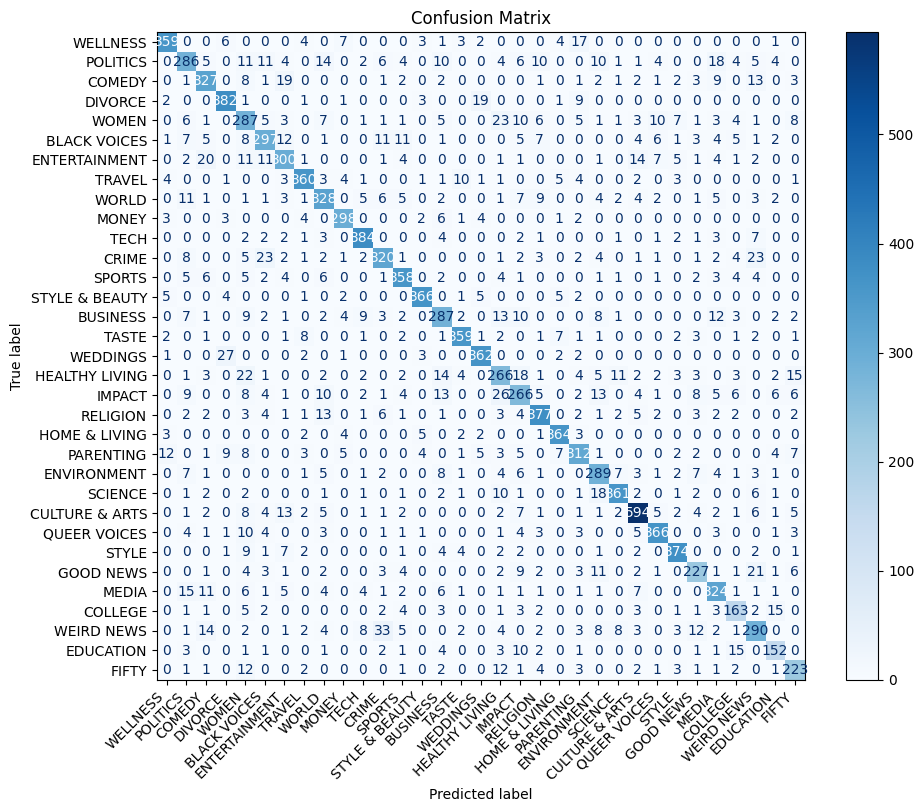

In [80]:
predictions = predict(model_html, encoded_inputs)
draw_confusion_matrix(labels, predictions)

## SHAP 

The following SHAP cells are only examples and the functions are mainly for converting different data formats. Therefore, the syntax here is not really meaningful. We will focus on the illustrations and the indices as arguments can be changed for other samples.

In [84]:
eval_path = r"/kaggle/input/news-classification/classification/classification_news_eval.jsonl"

eval_data = pd.read_json(eval_path, lines=True)

eval_texts = concatenate_naive(eval_data)

eval_labels = eval_data["category"]

In [115]:
classifier_html = transformers.pipeline(
    "text-classification",
    model=model_html,
    tokenizer=tokenizer,
    device=0,
    top_k=None,
)
text = eval_texts[0]
print(eval_texts[0], eval_labels[0])
classifier([text])

7 Risks That Are Making Climate Change Into One of the Biggest Security Threats of the 21st Century[SEP]Lukas Rüttinger, ContributorSenior Project Manager at adelphi[SEP]https://www.huffingtonpost.com/entry/7-risks-that-are-making-climate-change-into-one-of-the-biggest-security-threats-of-the-21st-century_b_7078826.html[SEP]Climate change is advancing. Its effects can be felt already today and will increase significantly in the coming decades even if the global community sets ambitious targets for reducing emissions at the end-of-year climate change negotiations in Paris.[SEP]2015-04-17 00:00:00 ENVIRONMENT


[[{'label': 'ENVIRONMENT', 'score': 0.9445024728775024},
  {'label': 'IMPACT', 'score': 0.015764180570840836},
  {'label': 'WORLD', 'score': 0.015558971092104912},
  {'label': 'SCIENCE', 'score': 0.005295137409120798},
  {'label': 'POLITICS', 'score': 0.004944005515426397},
  {'label': 'BUSINESS', 'score': 0.003385745920240879},
  {'label': 'EDUCATION', 'score': 0.0008875313214957714},
  {'label': 'MEDIA', 'score': 0.0008680898463353515},
  {'label': 'HEALTHY LIVING', 'score': 0.0007154382183216512},
  {'label': 'RELIGION', 'score': 0.0006133432034403086},
  {'label': 'WEDDINGS', 'score': 0.0005870679160580039},
  {'label': 'GOOD NEWS', 'score': 0.0005777138285338879},
  {'label': 'STYLE', 'score': 0.0005243780906312168},
  {'label': 'DIVORCE', 'score': 0.0005108184413984418},
  {'label': 'WELLNESS', 'score': 0.0004940208746120334},
  {'label': 'SPORTS', 'score': 0.00048595681437291205},
  {'label': 'CULTURE & ARTS', 'score': 0.00045353456516750157},
  {'label': 'CRIME', 'score': 0.000

In [107]:
import shap
mis_df = pd.read_csv(r"/kaggle/input/news-mismatches/news_mismatches - news_mismatches.csv", encoding="utf-8")
mis_texts, mis_trues, mis_preds = mis_df["text"], mis_df["true"], mis_df["pred"]

In [119]:
def generate_shap_graph_convert(index, classifer):
    explainer = shap.Explainer(classifier)
    sample = mis_texts[index]
    sample = sample.replace("<headline>", "").replace("</headline>", "[SEP]").replace("<authors>", "").replace("</authors>", "[SEP]").replace("<description>", "").replace("</description>", "[SEP]").replace("<link>", "").replace("</link>", "[SEP]").replace("<date>", "").replace("</date>", "[SEP]")
    
    shap_values = explainer([sample])
    
    import matplotlib.pyplot as plt
    print(f"Pred: {mis_preds[index]}")
    shap.plots.text(shap_values[:, :, mis_preds[index]])
    print(f"True: {mis_trues[index]}")
    shap.plots.text(shap_values[:, :, mis_trues[index]])
    plt.tight_layout()
    plt.show()

In [120]:
def generate_shap_graph(index, classifier):
    explainer = shap.Explainer(classifier)
    sample = mis_texts[index]
    shap_values = explainer([sample])
    
    import matplotlib.pyplot as plt
    print(f"Pred: {mis_preds[index]}")
    shap.plots.text(shap_values[:, :, mis_preds[index]])
    print(f"True: {mis_trues[index]}")
    shap.plots.text(shap_values[:, :, mis_trues[index]])
    plt.tight_layout()
    plt.savefig("shap.png")
    plt.show()

In [121]:
generate_shap_graph(6, classifier_html)

Pred: COMEDY


True: MEDIA


<Figure size 640x480 with 0 Axes>

In [122]:
classifier_sep = transformers.pipeline(
    "text-classification",
    model=model_sep,
    tokenizer=tokenizer,
    device=0,
    top_k=None,
)
text = eval_texts[0]
print(eval_texts[0], eval_labels[0])
classifier([text])

7 Risks That Are Making Climate Change Into One of the Biggest Security Threats of the 21st Century[SEP]Lukas Rüttinger, ContributorSenior Project Manager at adelphi[SEP]https://www.huffingtonpost.com/entry/7-risks-that-are-making-climate-change-into-one-of-the-biggest-security-threats-of-the-21st-century_b_7078826.html[SEP]Climate change is advancing. Its effects can be felt already today and will increase significantly in the coming decades even if the global community sets ambitious targets for reducing emissions at the end-of-year climate change negotiations in Paris.[SEP]2015-04-17 00:00:00 ENVIRONMENT


[[{'label': 'ENVIRONMENT', 'score': 0.9445024728775024},
  {'label': 'IMPACT', 'score': 0.015764180570840836},
  {'label': 'WORLD', 'score': 0.015558971092104912},
  {'label': 'SCIENCE', 'score': 0.005295137409120798},
  {'label': 'POLITICS', 'score': 0.004944005515426397},
  {'label': 'BUSINESS', 'score': 0.003385745920240879},
  {'label': 'EDUCATION', 'score': 0.0008875313214957714},
  {'label': 'MEDIA', 'score': 0.0008680898463353515},
  {'label': 'HEALTHY LIVING', 'score': 0.0007154382183216512},
  {'label': 'RELIGION', 'score': 0.0006133432034403086},
  {'label': 'WEDDINGS', 'score': 0.0005870679160580039},
  {'label': 'GOOD NEWS', 'score': 0.0005777138285338879},
  {'label': 'STYLE', 'score': 0.0005243780906312168},
  {'label': 'DIVORCE', 'score': 0.0005108184413984418},
  {'label': 'WELLNESS', 'score': 0.0004940208746120334},
  {'label': 'SPORTS', 'score': 0.00048595681437291205},
  {'label': 'CULTURE & ARTS', 'score': 0.00045353456516750157},
  {'label': 'CRIME', 'score': 0.000

In [123]:
generate_shap_graph_convert(99,classifier_sep)

Pred: BLACK VOICES


True: POLITICS


<Figure size 640x480 with 0 Axes>

In [126]:
def generate_shap_graph_from_eval(index, classifier):
    explainer = shap.Explainer(classifier)
    sample = eval_texts[index]
    # sample = sample.replace("<headline>", "").replace("</headline>", "[SEP]").replace("<authors>", "").replace("</authors>", "[SEP]").replace("<description>", "").replace("</description>", "[SEP]").replace("<link>", "").replace("</link>", "[SEP]").replace("<date>", "").replace("</date>", "[SEP]")
    result = classifier([sample])
    shap_values = explainer([sample])
    
    import matplotlib.pyplot as plt
    print(f"Pred: {result[0][0]['label']}")
    shap.plots.text(shap_values[:, :, result[0][0]['label']])
    print(f"True: {eval_labels[index]}")
    shap.plots.text(shap_values[:, :, eval_labels[index]])
    plt.tight_layout()
    plt.show()

In [129]:
generate_shap_graph_from_eval(5383, classifier_html)

Pred: DIVORCE


True: DIVORCE


<Figure size 640x480 with 0 Axes>